In [1]:
from baseline_cnn import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# net=Nnet()

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     net = nn.DataParallel(net)

# net.to(computing_device)
net=Nnet().to(computing_device)
net.apply(weights_init)

# Print the model
print(net)

#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()


#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(),lr = 0.001)

CUDA is supported
Nnet(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [4]:
transform = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()])
train_set = loader('train.pickle', transform=transform)
valid_set = loader('valid.pickle', transform=transform)

batch_size = 100
random_seed= 42 #should be torch.manuel_seed(42) ?
shuffling = True


#make shuffle true for real training
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffling)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=shuffling)

In [5]:
total_loss = []
total_accu = []

train_losses = []
train_accuracies = []

avg_minibatch_loss = []
avg_minibatch_accu = []
N = 50

all_models = []

valid_losses = []
valid_accuracies = []

xnloss = []

start = time.monotonic()

# torch.manual_seed(random_seed)

#num of epochs
n_epochs = 15
stop = True

#Helper function for calculating accuracy
def calculate_accu(outputs, labels, batch_size):
    num_correct = torch.sum(torch.max(outputs, dim = 1)[1] == labels).item()
    return num_correct / batch_size

for epoch in range(n_epochs):
    
    epoch_start = time.monotonic()
    N_minibatch_loss = 0.0
    net.train()
    
    N_minibatch_accu = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print('mini_batch %d\r' % minibatch_count, end="")
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        
        labels = labels.type(torch.LongTensor)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        
        
        loss = criterion(outputs, labels)
        accu = calculate_accu(outputs, labels, batch_size)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        total_accu.append(accu)
        
        N_minibatch_loss += loss #N_minibatch_loss += loss.item()
        N_minibatch_accu += accu
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            N_minibatch_accu /= N
            
            print('Epoch %d, avg miba %d loss: %.3f\r' % (epoch + 1, minibatch_count+1, N_minibatch_loss), end="")
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            avg_minibatch_accu.append(N_minibatch_accu)
            
            N_minibatch_loss = 0.0
            N_minibatch_accu = 0.0
    
    train_losses.append(np.average(total_loss))
    train_accuracies.append(np.average(total_accu))
    
    print("Finished", epoch + 1, "epochs of training")
    # TODO: Implement validation #with torch.no_grad():
    
    epoch_RT = time.monotonic() - epoch_start
    formattedTime = time.strftime("%H:%M:%S", time.gmtime(epoch_RT))
    print('RUNTIME FOR EPOCH: ', epoch + 1, formattedTime)
    
   
    print("now doing validation performance")
    
    val_start = time.monotonic()
    net.eval()
    
    with torch.no_grad():
        
        valid_loss = 0
        valid_accu = 0
        
        for minibatch_count, (images, labels) in enumerate(valid_loader, 0):
            
            #Apply current model to the data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(images)
            
            valid_accu += calculate_accu(outputs, labels, batch_size)
            valid_loss += criterion(outputs, labels).item()
        
        avg_valid_accu = valid_accu/minibatch_count
        avg_valid_loss = valid_loss/minibatch_count
        
        val_RT = time.monotonic() - val_start
        formattedTime = time.strftime("%H:%M:%S", time.gmtime(val_RT))
        print('RUNTIME OF VAL PERFORMANCE: ', formattedTime)   
        
        print("Loss for validation set is %.3f" % avg_valid_loss)
        print("Accuracy for validation set is %.2f" % (avg_valid_accu * 100), "%")
            
        if len(xnloss) < 2:
            xnloss.append(avg_valid_loss)
        elif xnloss[-2] < xnloss[-1] < avg_valid_loss:
            xnloss.append(avg_valid_loss)
            if stop:
                print("EARLY STOPPED AT EPOCH: ", epoch + 1)
                break
        else:
            xnloss.append(avg_valid_loss)
            
        valid_accuracies.append(avg_valid_accu)
    
    duration = time.monotonic() - start
    formattedTime = time.strftime("%H:%M:%S", time.gmtime(duration))
    print('TOTAL RUNTIME SO FAR :) ', formattedTime)
    print()
    #saving model
#     path = 'saved_models/baseline_fold2_' + time.strftime("%b%d/", time.localtime())
#     os.makedirs(path, 0o777, exist_ok=True)
#     savepath = path  + time.strftime("%I_%M%p", time.localtime()) + '.pt'
#     torch.save(net, savepath)
    
finalTime = time.monotonic() - start
formattedTime = time.strftime("%H:%M:%S", time.gmtime(finalTime))
print('Total time with ESing: ', formattedTime)

Finished 1 epochs of training.197
RUNTIME FOR EPOCH:  1 00:00:08
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.292
Accuracy for validation set is 92.98 %
TOTAL RUNTIME SO FAR :)  00:00:08

Finished 2 epochs of training.077
RUNTIME FOR EPOCH:  2 00:00:07
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.211
Accuracy for validation set is 95.48 %
TOTAL RUNTIME SO FAR :)  00:00:16

Finished 3 epochs of training.058
RUNTIME FOR EPOCH:  3 00:00:07
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.184
Accuracy for validation set is 95.66 %
TOTAL RUNTIME SO FAR :)  00:00:25

Finished 4 epochs of training.044
RUNTIME FOR EPOCH:  4 00:00:07
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.238
Accuracy for validation set is 94.82 %
TOTAL RUNTIME SO FAR :)  00:00:33

Finished 5 epochs of trainin

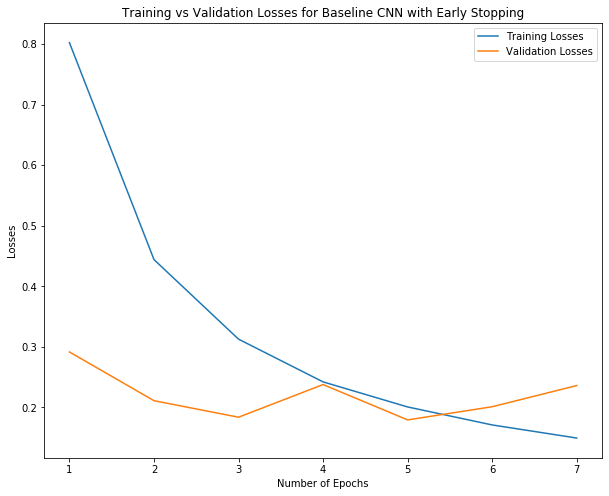

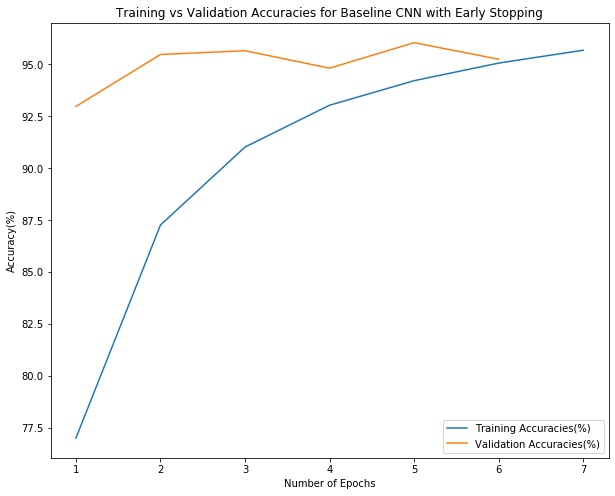

In [6]:
# path = 'saved_models/' + time.strftime("%b%d/", time.localtime())
# os.makedirs(path, 0o777, exist_ok=True)
# lastmodel = path  + 'lastModel.pt'
# torch.save(net, 'baseline_fold2.pt')

graph_path = 'graphs/' + time.strftime("%I_%M%p", time.localtime())  + '_losses.png'
# os.makedirs(path, 0o777, exist_ok=True)
# graph_savpth = graph_path  + time.strftime("%I_%M%p", time.localtime()) + '.png'


graph_title = 'Training vs Validation Losses for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(xnloss) + 1), xnloss, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend() #loc=4)
fig.savefig(graph_path)

graph_title = 'Training vs Validation Accuracies for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accuracies) + 1), np.array(train_accuracies) * 100, label='Training Accuracies(%)')
ax.plot(np.arange(1, len(valid_accuracies) + 1), np.array(valid_accuracies) * 100, label='Validation Accuracies(%)')
ax.set(xlabel='Number of Epochs', ylabel='Accuracy(%)',
           title=graph_title)
leg = ax.legend() #loc=4)

accupath = 'graphs/' + time.strftime("%I_%M%p", time.localtime()) + '_accus.png'
fig.savefig(accupath)
plt.show()

In [7]:
test_set = loader('test.pickle', transform=transform)

# batch_size = 100
# random_seed= 42
# shuffling = True


#make shuffle true for real training
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=shuffling)


In [8]:
def per_class_model_performance(performances):
    
    perf_df = []
    
    #for each class, calculate accuracy, recall, precision and bcr
    for i in range(len(performances)):
        
        cur_perf = performances[i]
        accu, recall, precision, bcr = get_per_class_values(cur_perf)
        
        perf_df.append([accu, precision, recall, bcr])
        
    #make it to a dataframe
    perf_df = pd.DataFrame(perf_df)
    perf_df.columns = ['Accuracy', 'Precision', 'Recall', 'BCR']
    
    return perf_df
 

#get measurement recall, accuracy, precision and bcr value for the current class
def get_per_class_values(cur_perf):    
    
    tp = cur_perf['TP']
    fp = cur_perf['FP']
    tn = cur_perf['TN']
    fn = cur_perf['FN']
    
    #accuracy
    accu = (tp + tn)/(tp + tn + fp + fn)
    
    #recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    #precision
    if fp + tp == 0:
        precision = 0
    else:
        precision = tp / (fp + tp)
        
    #bcr
    bcr = (precision + recall) / 2
    
    return accu, recall, precision, bcr


# In[ ]:


#Apply to test set and test Performances
all_class_performance = []
test_accuracies = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(44):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test_loader, 0):
        
#         print("current minibatch: ", minibatch_count)
        
        labels = labels.type(torch.LongTensor)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = net(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(44):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracies = (test_accu/minibatch_count)

print('The test accuracy is ' + "{0:.2f}".format(100 * test_accu/minibatch_count) + '%')

The test accuracy is 92.44%


In [9]:
rem = int((10000 * test_accu / minibatch_count) % 100)
accuFormat = "{}_{}".format(int(100 * test_accu/minibatch_count), rem)
print(accuFormat)

92_44


In [10]:
testAccu = accuFormat + 'accu'

config_path = 'configs/' + testAccu + '.txt'
f = open(config_path, "w")
f.write(str(net))
f.close()

model_path = 'models/' + testAccu + '.pt'
torch.save(net, model_path)